# Sleep Prediction
Here we try to use environmental parameters in addition to mood and activity characteristics to see if we are able to predict sleep quality.

## Features
In this analysis, we are going to consider the following features:
1. **Acitivity**: The main metrics for activity that we will use are:
    * Daily Steps
    * Intensity Levels
2. **Mood**: We have five metrics for mood:
    * Content
    * Lonely
    * Sadness
    * Stress
    * Energy Level 
3. **IEQ**: There are many measurements of IEQ that we consider:
    * CO$_2$
    * CO
    * PM$_{2.5}$
    * NO$_2$
    * TVOCs
    * Temperature
    * Relative Humidity
    
## Targets
The targets will be all metrics related to sleep quality:
1. **Self-Report**: There are four metrics for self-report sleep quality reported via EMA:
    * TST
    * SOL
    * NAW
    * Restfulness
2. **Fitbit-Measured**: There are also four metrics of sleep quality that we can use from Fitbit:
    * TST
    * SE
    * REM Percentage
    * Light Percentage
    * Deep Percentage

In [1]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
# general
import os
import sys
sys.path.append('../')
# user-defined functions
from src.visualization import visualize
# basic data science
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
# timeseries
from datetime import datetime, timedelta
# plottings
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

# Table of Contents
1. [Data Import](#data-import)
3. [Target Encoding](#encoding)
4. [Feature Engineering](#feature_engineering)
5. [Prediction](#prediction)
    1. [Fitbit Sleep Targets](#fitbit-sleep-prediction)
        1. TST
        2. SOL
        3. WASO
        4. REM:nREM
        5. SE
    2. [Self-Report Sleep Targets](#self-report-sleep-prediction)
        1. TST
        2. SOL
        3. NAW
        4. Restfulness
6. [Prediction with Encoded Features](#prediction_encoded)
7. [Final Analysis](#final_analysis)

<a id="data-import"></a>

# Data Import
For this analysis we want to only consider nights when we have _all_ the available data. These are also the nights that we have confirmed participants are home according to GPS traces. 

## Feature: IEQ
We start with IEQ data beacuse from previous analysis, this dataset has already been curated to include the relevant nights. However, there are quite a few columns that are not necessary for this analysis that have to be removed.

In [3]:
ieq_raw = pd.read_csv("../data/processed/beacon-fb_and_gps_filtered_summary-ux_s20.csv",parse_dates=["start_time","end_time"],infer_datetime_format=True)
ieq_raw["date"] = pd.to_datetime(ieq_raw["end_time"].dt.date)
ieq = ieq_raw[["start_time","end_time","date","beiwe","redcap","beacon","co2_median","co_median","pm2p5_mass_median","no2_median","temperature_c_median","rh_median"]]
ieq.rename({"date":"end_date"},axis="columns",inplace=True)
ieq.head()

,start_time,end_time,end_date,beiwe,redcap,beacon,co2_median,co_median,pm2p5_mass_median,no2_median,temperature_c_median,rh_median
0,2020-08-10 04:42:30,2020-08-10 12:35:30,2020-08-10,lkkjddam,12,21,1600.754959,10.359917,1.848583,1.593768,23.337500,33.0
1,2020-08-11 03:35:00,2020-08-11 12:36:30,2020-08-11,lkkjddam,12,21,1628.474180,6.429275,1.655522,1.597845,25.000000,34.0
2,2020-08-12 02:59:30,2020-08-12 10:52:30,2020-08-12,lkkjddam,12,21,1596.122408,10.271850,2.024990,1.603469,24.000000,33.0
3,2020-08-14 03:05:00,2020-08-14 11:23:30,2020-08-14,lkkjddam,12,21,1301.449844,7.232700,1.812659,1.592935,25.000000,33.0
4,2020-08-15 06:51:30,2020-08-15 11:30:00,2020-08-15,lkkjddam,12,21,1274.110350,10.886100,2.457356,1.606745,23.333333,34.0


## Feature: Activity
Activity data are essentially untouched from the raw format

In [4]:
activity_raw = pd.read_csv("../data/processed/fitbit-daily-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
activity = activity_raw[["timestamp","beiwe","steps","sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes"]]
activity.rename({"timestamp":"date"},axis="columns",inplace=True)
activity.head()

,date,beiwe,steps,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes
0,2020-05-13,hfttkth7,9207,1241,70,118,11
1,2020-05-14,hfttkth7,15207,614,263,134,23
2,2020-05-15,hfttkth7,14556,577,205,57,108
3,2020-05-16,hfttkth7,18453,760,176,24,151
4,2020-05-17,hfttkth7,15425,605,207,50,131


## Feature: Mood
We only want to consider mood data from the latest survey prior to the participant going to sleep so we only important the evening EMAs.

In [5]:
mood = pd.read_csv("../data/processed/beiwe-evening_ema-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
mood["date"] = pd.to_datetime(mood["timestamp"].dt.date)
mood.head()

,timestamp,beiwe,content,stress,lonely,sad,energy,redcap,beacon,date
0,2020-05-13 19:00:23,awa8uces,1.0,1.0,1.0,3.0,2.0,28,26.0,2020-05-13
1,2020-05-13 19:21:32,lkkjddam,0.0,2.0,3.0,1.0,0.0,12,21.0,2020-05-13
2,2020-05-13 19:30:38,rvhdl2la,2.0,1.0,0.0,0.0,1.0,29,NaN,2020-05-13
3,2020-05-13 20:07:04,xxvnhauv,1.0,3.0,1.0,2.0,0.0,21,22.0,2020-05-13
4,2020-05-13 20:25:07,xdbdrk6e,2.0,1.0,2.0,1.0,3.0,23,24.0,2020-05-13


## Target: Self-Report Sleep Quality (SRSQ)
The self-reported sleep quality comes from the morning EMAs.

In [6]:
srsq_raw = pd.read_csv("../data/processed/beiwe-morning_ema-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
srsq_raw["date"] = pd.to_datetime(srsq_raw["timestamp"].dt.date)
srsq = srsq_raw[["timestamp","date","beiwe","redcap","beacon","tst","sol","naw","restful"]]
srsq.rename({"date":"end_date"},axis="columns",inplace=True)
srsq.head()

,timestamp,end_date,beiwe,redcap,beacon,tst,sol,naw,restful
0,2020-05-13 09:10:27,2020-05-13,qh34m4r9,68,19.0,8.0,20.0,2.0,3.0
1,2020-05-13 09:15:49,2020-05-13,awa8uces,28,26.0,2.0,10.0,3.0,1.0
2,2020-05-13 09:42:19,2020-05-13,xxvnhauv,21,22.0,6.0,30.0,3.0,1.0
3,2020-05-13 09:43:27,2020-05-13,rvhdl2la,29,NaN,5.3,5.0,2.0,2.0
4,2020-05-13 10:11:51,2020-05-13,q5y11ytm,48,NaN,2.0,10.0,0.0,0.0


## Target: Fitbit Sleep Quality (FBSQ)
Fitbit sleep summary data is imported below.

In [7]:
fbsq_raw = pd.read_csv("../data/processed/fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time","start_date","end_date"],infer_datetime_format=True)
fbsq = fbsq_raw[["start_time","end_time","start_date","end_date","beiwe","redcap","beacon","tst_fb","efficiency","rem_percent","light_percent","deep_percent"]]
fbsq.rename({"tst_fb":"tst","efficiency":"se"},axis="columns",inplace=True)
fbsq.head()

,start_time,end_time,start_date,end_date,beiwe,redcap,beacon,tst,se,rem_percent,light_percent,deep_percent
0,2020-05-14 00:27:00,2020-05-14 07:13:00,2020-05-14,2020-05-14,hfttkth7,NaN,NaN,6.316667,93.349754,0.216359,0.562005,0.221636
1,2020-05-14 23:53:30,2020-05-15 08:06:30,2020-05-14,2020-05-15,hfttkth7,NaN,NaN,6.533333,79.513185,0.119898,0.637755,0.242347
2,2020-05-15 23:28:00,2020-05-16 04:57:00,2020-05-15,2020-05-16,hfttkth7,NaN,NaN,4.783333,87.234043,0.174216,0.662021,0.163763
3,2020-05-17 02:01:30,2020-05-17 09:28:30,2020-05-17,2020-05-17,hfttkth7,NaN,NaN,6.716667,90.156600,0.205955,0.600496,0.193548
4,2020-05-18 00:24:00,2020-05-18 07:20:00,2020-05-18,2020-05-18,hfttkth7,NaN,NaN,5.850000,84.375000,0.250712,0.475783,0.273504


## Target: Combined Sleep Quality (CSQ)
The sleep quality dataset has already been created from a previous analysis so we simply just have to import it.

I don't think we will be using this dataset, but we might as well keep it here.

In [8]:
sleep_quality = pd.read_csv("../data/processed/beiwe_fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time","start_date","end_date","date"],infer_datetime_format=True)
csq = sleep_quality[["start_time","end_time","start_date","end_date","date","beiwe","redcap","beacon","tst_ema","sol_ema","naw_ema","restful_ema","tst_fb","efficiency","rem_percent","nrem_percent"]]
csq.head() # Combined Sleep Quality (csq)

,start_time,end_time,start_date,end_date,date,beiwe,redcap,beacon,tst_ema,sol_ema,naw_ema,restful_ema,tst_fb,efficiency,rem_percent,nrem_percent
0,2020-05-14 01:06:00,2020-05-14 11:39:30,2020-05-14,2020-05-14,2020-05-14,15tejjtw,45.0,NaN,9.0,30.0,5.0,2.0,8.766667,83.096367,0.231939,0.768061
1,2020-05-16 02:19:00,2020-05-16 10:00:30,2020-05-16,2020-05-16,2020-05-16,15tejjtw,45.0,NaN,9.0,15.0,2.0,2.0,6.600000,85.900217,0.123737,0.876263
2,2020-05-17 00:27:00,2020-05-17 10:28:00,2020-05-17,2020-05-17,2020-05-17,15tejjtw,45.0,NaN,9.0,30.0,1.0,2.0,8.850000,88.352745,0.254237,0.745763
3,2020-05-18 01:37:00,2020-05-18 10:59:30,2020-05-18,2020-05-18,2020-05-18,15tejjtw,45.0,NaN,9.0,25.0,2.0,1.0,7.966667,85.053381,0.207113,0.792887
4,2020-05-21 23:59:30,2020-05-22 09:27:30,2020-05-21,2020-05-22,2020-05-22,15tejjtw,45.0,NaN,9.0,20.0,2.0,2.0,8.316667,87.852113,0.264529,0.735471


<a id="encoding" ></a>

# Target Encoding
We will encode all the target sleep quality variables as binary where 0 represents poor/negative outcomes and 1 are good/positive outcomes.

In [142]:
def plot_distribution(df, variable,**kwargs):
    """plots distribution of values"""
    fig, ax = plt.subplots(figsize=(12,4))
    # density plot
    sns.kdeplot(x=variable,cut=0,data=df,zorder=2,
                linewidth=3,color="black",ax=ax)
    # x-axis
    plt.xticks(fontsize=14)
    ax.set_xlabel(variable.upper(),fontsize=16)
    if "xlim" in kwargs.keys():
        ax.set_xlim(kwargs["xlim"])
    else:
        ax.set_xlim([0,max(df[variable])])
    # cumulative
    ax2 = ax.twinx()
    sns.kdeplot(x=variable,cut=0,data=df,cumulative=True,zorder=1,
                linewidth=2,color="firebrick",ax=ax2)
    # y-axis
    ax.set_yticks([])
    ax.set_ylabel("")
    ax2.set_ylabel("")
    ax2.set_ylim([0,1])
    ax2.set_yticks([0,0.25,0.5,0.75,1])
    plt.yticks(fontsize=14)
    # remainder
    for loc in ["left","top"]:
        ax.spines[loc].set_visible(False)
        ax2.spines[loc].set_visible(False)
    plt.show()
    plt.close()

## SE
Based on a discussion with Dr. Schnyer, he suggested this scale (with some minor tweaks in language from me):

| SE | Rating | Value |
| --- | --- | --- |
| >90% | Excellent | 3 |
| 85% - 90% | Good | 2 |
| 80% - 85% | Typical | 1 |
| <80% | Poor | 0 |



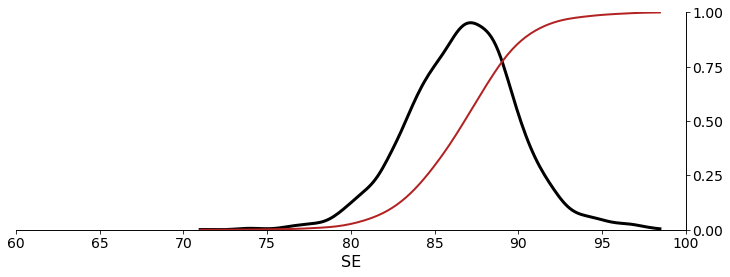

In [143]:
plot_distribution(fbsq,"se",xlim=[60,100])

Here, we just say the SE is good (1) when above 85%, otherwise it is bad (0).

In [144]:
def encode_se(value):
    """returns encoded value for se"""
    if value >= 85:
        return 1
    else:
        return 0

## TST
Based on a "traditional" recommendations, we can lump `tst` into three categories:

| TST | Rating | Value |
| --- | --- | --- |
| >9 h | High | 0 |
| 7-9 h | Typical | 1 |
| <7 h | Low | 0 |

In [10]:
def encode_tst(value):
    """returns score of tsts"""
    if value > 9:
        return 0
    elif value >= 7:
        return 1
    else:
        return 0

## REM
Ideally you should be spending between 20% and 25% of your night in REM sleep.

In [11]:
def encode_rem(value):
    """returns score of REM percent"""
    if value >= 0.2 and value <= 0.25:
        return 1
    else:
        return 0

## Light Sleep
Light Sleep should be a maximum of about 60% but we also don't want too little. 

In [12]:
def encode_light(value):
    """returns score of light percent"""
    if value >= 0.4 and value <= 0.6:
        return 1
    else:
        return 0

## Deep Sleep
Deep sleep should encompass about 12% to 23% of your night.

In [13]:
def encode_deep(value):
    """returns score of deep percent"""
    if value >= 0.12 and value <= 0.23:
        return 1
    else:
        return 0

## SOL
The National Sleep Foundation says 30 minutes or less is a marker for good sleep quality. However, looking at the distribution of values, perhaps we should alter that threshold since many of the participants fall asleep faster than that.

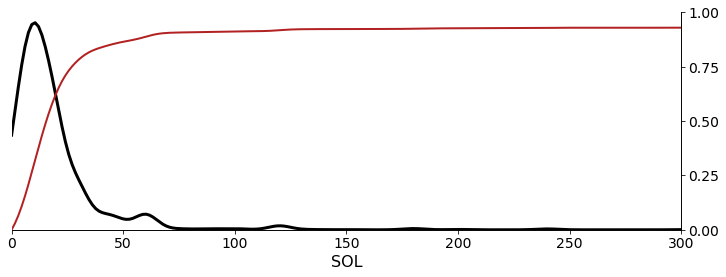

In [118]:
plot_distribution(srsq,"sol")

In [119]:
def encode_sol(value):
    """returns score of sol"""
    if value < 15:
        return 1
    else:
        return 0

## NAW
We group NAW into a good and bad category based on [Ohayon et al., 2017](https://www.sciencedirect.com/science/article/pii/S2352721816301309?casa_token=56p9duOGsL4AAAAA:tmPWLtzq0Z9zGGq-w0qWBXJT-VEDeoZ0dOwL06G-BwbWMHA3uT_KBjxd08HPyFZWNqIpm_0m).

| NAW | Rating | Value |
| --- | --- | --- |
| 0 or 1 | Good | 1 |
| >1 | Bad | 0 |

In [120]:
def encode_naw(value):
    """returns score of naw"""
    if value < 2:
        return 1
    else:
        return 0

## Restfulness
Restfulness is one of the five metrics that is rated on a 0 to 3 Likert scale. So we can create a more generic function here for later use.

In [121]:
def encode_likert(value):
    """returns score for a 0-3 Likert measurement"""
    if value > 1:
        return 1
    else:
        return 0

## Encoding Sleep Quality

### Self-Report Sleep
We start with self-report metrics of sleep quality.

In [122]:
for sm, f in zip(["tst","sol","naw","restful"], [encode_tst,encode_sol,encode_naw,encode_likert]):
    srsq[f"{sm}_binary"] = srsq.apply(lambda x: f(x[sm]), axis="columns")
    
srsq.head()

,timestamp,end_date,beiwe,redcap,beacon,tst,sol,naw,restful,tst_binary,sol_binary,naw_binary,restful_binary
0,2020-05-13 09:10:27,2020-05-13,qh34m4r9,68,19.0,8.0,20.0,2.0,3.0,1,0,0,1
1,2020-05-13 09:15:49,2020-05-13,awa8uces,28,26.0,2.0,10.0,3.0,1.0,0,1,0,0
2,2020-05-13 09:42:19,2020-05-13,xxvnhauv,21,22.0,6.0,30.0,3.0,1.0,0,0,0,0
3,2020-05-13 09:43:27,2020-05-13,rvhdl2la,29,NaN,5.3,5.0,2.0,2.0,0,1,0,1
4,2020-05-13 10:11:51,2020-05-13,q5y11ytm,48,NaN,2.0,10.0,0.0,0.0,0,1,1,0


### Fitbit Sleep
And now Fitbit-measured sleep quality.

In [123]:
for sm, f in zip(["tst","se","rem_percent","light_percent","deep_percent"], [encode_tst,encode_se,encode_rem,encode_light,encode_deep]):
    fbsq[f"{sm}_binary"] = fbsq.apply(lambda x: f(x[sm]), axis="columns")
    
fbsq.head()

,start_time,end_time,start_date,end_date,beiwe,redcap,beacon,tst,se,rem_percent,light_percent,deep_percent,tst_binary,se_binary,rem_percent_binary,light_percent_binary,deep_percent_binary
0,2020-05-14 00:27:00,2020-05-14 07:13:00,2020-05-14,2020-05-14,hfttkth7,NaN,NaN,6.316667,93.349754,0.216359,0.562005,0.221636,0,1,1,1,1
1,2020-05-14 23:53:30,2020-05-15 08:06:30,2020-05-14,2020-05-15,hfttkth7,NaN,NaN,6.533333,79.513185,0.119898,0.637755,0.242347,0,0,0,0,0
2,2020-05-15 23:28:00,2020-05-16 04:57:00,2020-05-15,2020-05-16,hfttkth7,NaN,NaN,4.783333,87.234043,0.174216,0.662021,0.163763,0,0,0,0,1
3,2020-05-17 02:01:30,2020-05-17 09:28:30,2020-05-17,2020-05-17,hfttkth7,NaN,NaN,6.716667,90.156600,0.205955,0.600496,0.193548,0,1,1,0,1
4,2020-05-18 00:24:00,2020-05-18 07:20:00,2020-05-18,2020-05-18,hfttkth7,NaN,NaN,5.850000,84.375000,0.250712,0.475783,0.273504,0,0,0,1,0


<a id="feature_engineering" ></a>

# Feature Engineering
In the following cells, we encode the various features to binary outcomes and combine the features into one dataset. 

## Encoding
We encode each of the features into a binary outcome.

### Activity

#### Activity Level
Encoding the activity levels can be accomplished by looking at recommendations from the American College of Sports Medicine. ACSM states that adults should do:
* Moderate Intensity: 150 - 300 minutes per week, or
* Vigorous: 75 - 150 minutes per week, or
* Combination

Fitbit divides activity level into multiple categories that are not exactly the same label as what the ACSM states. While the cutoff points are not very clear, they are most likely:
* Sedentary: MET < 1
* Light: MET < 3
* Fairly: MET < 6 (ACSM Moderate)
* Very: > 6 (ACSM Vigorous)

We look on a per-day basis so the cutoffs discussed above can be altered:
* Moderate: 21 - 43 minutes per day
* Vigorous: 11 - 21 minutes per day

We will start with what seems the most straightforward separation: getting enough moderate and vigorous activity per day. Based on the guidelines, one needs twice as many moderate minutes as vigorous minutes of activity. In order to address the "combination" category, we can multiply the number of vigorous minutes by 2 and add this value to the moderately active minutes which will allow us to compare this value to the moderately active minutes threshold. 

In [124]:
def encode_activity_level(row, moderate_threshold=21):
    """returns score of activity level"""
    if row["fairly_active_minutes"] + row["very_active_minutes"]*2 > moderate_threshold:
        return 1
    else:
        return 0

#### Number of Steps
An attainable goal that all adults should strive for is about 10,000 steps a day

In [125]:
def econde_steps(value):
    if value > 10000:
        return 1
    else:
        return 0

In [126]:
activity["active_binary"] = activity.apply(lambda row: encode_activity_level(row), axis="columns")
activity["steps_binary"] = activity.apply(lambda x: econde_steps(x["steps"]), axis="columns")
activity.head()

,date,beiwe,steps,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes,active_binary,steps_binary,end_date
0,2020-05-13,hfttkth7,9207,1241,70,118,11,1,0,2020-05-14
1,2020-05-14,hfttkth7,15207,614,263,134,23,1,1,2020-05-15
2,2020-05-15,hfttkth7,14556,577,205,57,108,1,1,2020-05-16
3,2020-05-16,hfttkth7,18453,760,176,24,151,1,1,2020-05-17
4,2020-05-17,hfttkth7,15425,605,207,50,131,1,1,2020-05-18


### Mood
Each of the mood scores (except for `energy`) are on the same Likert scale as `restful` so we can just use that function to encode the mood scores. For `energy`, there are only two negative responses so we will consider the `Neutral` response as a positive score which allows us to use the same function.

In [127]:
for variable in ["content","stress","lonely","sad","energy"]:
    mood[f"{variable}_binary"] = mood.apply(lambda x: encode_likert(x[variable]), axis="columns")
    
mood.head()

,timestamp,beiwe,content,stress,lonely,sad,energy,redcap,beacon,date,content_binary,stress_binary,lonely_binary,sad_binary,energy_binary
0,2020-05-13 19:00:23,awa8uces,1.0,1.0,1.0,3.0,2.0,28,26.0,2020-05-13,0,0,0,1,1
1,2020-05-13 19:21:32,lkkjddam,0.0,2.0,3.0,1.0,0.0,12,21.0,2020-05-13,0,1,1,0,0
2,2020-05-13 19:30:38,rvhdl2la,2.0,1.0,0.0,0.0,1.0,29,NaN,2020-05-13,1,0,0,0,0
3,2020-05-13 20:07:04,xxvnhauv,1.0,3.0,1.0,2.0,0.0,21,22.0,2020-05-13,0,1,0,1,0
4,2020-05-13 20:25:07,xdbdrk6e,2.0,1.0,2.0,1.0,3.0,23,24.0,2020-05-13,1,0,1,0,1


### IEQ
For the IEQ data, we want to determine whether the concentrations are low or high depending on the participant's own environment. So the process will involve looking at each of the IEQ measurements from each participant, finding the mean of those nights, and then determining 1 (low) or 0 (high).

In [128]:
def encode_ieq(value, threshold):
    """Scores the IEQ parameter"""
    if value <= threshold:
        return 1
    else:
        return 0

In [129]:
ieq_bi = pd.DataFrame()
stat="median"
for pt in ieq["beiwe"].unique():
    ieq_pt = ieq[ieq["beiwe"] == pt]
    for pollutant in ["co2", "co","pm2p5_mass","no2","temperature_c","rh"]:
        mean_night = np.nanmean(ieq_pt[f"{pollutant}_{stat}"])
        ieq_pt[f"{pollutant}_{stat}_binary"] = ieq_pt.apply(lambda x: encode_ieq(x[f"{pollutant}_{stat}"],mean_night), axis="columns")
        
    ieq_bi = ieq_bi.append(ieq_pt)
    
ieq_bi.head()

,start_time,end_time,end_date,beiwe,redcap,beacon,co2_median,co_median,pm2p5_mass_median,no2_median,temperature_c_median,rh_median,co2_median_binary,co_median_binary,pm2p5_mass_median_binary,no2_median_binary,temperature_c_median_binary,rh_median_binary
0,2020-08-10 04:42:30,2020-08-10 12:35:30,2020-08-10,lkkjddam,12,21,1600.754959,10.359917,1.848583,1.593768,23.337500,33.0,0,0,1,1,1,1
1,2020-08-11 03:35:00,2020-08-11 12:36:30,2020-08-11,lkkjddam,12,21,1628.474180,6.429275,1.655522,1.597845,25.000000,34.0,0,1,1,1,0,0
2,2020-08-12 02:59:30,2020-08-12 10:52:30,2020-08-12,lkkjddam,12,21,1596.122408,10.271850,2.024990,1.603469,24.000000,33.0,0,0,1,0,1,1
3,2020-08-14 03:05:00,2020-08-14 11:23:30,2020-08-14,lkkjddam,12,21,1301.449844,7.232700,1.812659,1.592935,25.000000,33.0,1,1,1,1,0,1
4,2020-08-15 06:51:30,2020-08-15 11:30:00,2020-08-15,lkkjddam,12,21,1274.110350,10.886100,2.457356,1.606745,23.333333,34.0,1,0,0,0,1,0


## Correcting EMA Timestamp
The EMAs are tricky because they can be submitted at any time. So we need to make sure that the `date` column we merge along corresponds to the correct end date of the Fitbit sleep event. 

In [130]:
def correct_ema_date(ema, fbs, threshold=3, verbose=True):
    """adds new column corresponding to the day when the participant woke"""
    ema_with_dates = pd.DataFrame()
    for pt in ema["beiwe"].unique():
        end_dates = []
        if verbose:
            print("Participant:", pt)
        # getting data per participant
        ema_pt = ema[ema["beiwe"] == pt]
        try:
            fb_pt = fbs[fbs["beiwe"] == pt]
        except KeyError:
            if verbose:
                print("\tNo Fitbit Data")
            continue
        # looping through submission times
        for submission_time in ema_pt["timestamp"]:
            end_dates.append(np.nan) # appending to keep same length
            fb_since = fb_pt[fb_pt["start_time"] > submission_time] # Fitbit sleep data since the EMA was submitted
            try:
                dt = fb_since["start_time"].iloc[0] - submission_time # get time difference between when the EMA was submitted and the Fitbit started logging data
            except IndexError:
                if verbose:
                    print("\tNo Fitbit Data after EMA submission of", submission_time.date())
                continue
            if dt < timedelta(hours=threshold): # if the EMA was submitted a certain time before the sleep event, add the actual date
                if submission_time.hour > 12:
                    end_dates[-1] = submission_time.date() + timedelta(days=1)
                else:
                    end_dates[-1] = submission_time.date()
                    
        ema_pt["end_date"] = pd.to_datetime(end_dates)
        if verbose:
            print((ema_pt["date"] == ema_pt["end_date"]).value_counts())
            print()
        ema_with_dates = ema_with_dates.append(ema_pt)
        
    return ema_with_dates

We get a new mood dataframe with the `end_date` column which we will merge along.

In [131]:
new_mood = correct_ema_date(mood, fbsq, threshold=5, verbose=False)

## Correcting Activity Date
The activity date corresponds to the day on which the participant was that active. Since all the other dates are relative to when the participant wakes up, we have to add a day to the activity data.

In [132]:
activity["end_date"] = activity["date"] + timedelta(days=1)

## Combining
Now that we have encoded all the target variables, we can combine them in different datasets to get a better sense of the available data for prediction. The common link between all the datasets will be the IEQ dataset since we are aiming to use those variables as a novel approach to prediction.

### IEQ Only
Considering the base case: just IEQ observations.

In [133]:
print("Number of observations:",len(ieq_bi))

Number of observations: 395


### Activity and IEQ

In [134]:
ieq_and_activity = ieq_bi.merge(right=activity,on=["end_date","beiwe"])
print("Number of observations:",len(ieq_and_activity))

Number of observations: 374


<div class="alert alert-block alert-success">
 
By including activity data, we only lose 21 observations from the original target dataset. This percent loss might even be smaller considering we haven't combined the data with the target datasets yet.
    
</div>

### Mood and IEQ

In [135]:
ieq_and_mood = ieq_bi.merge(right=new_mood,on=["end_date","beiwe","redcap","beacon"])
print("Number of observations:",len(ieq_and_mood))

Number of observations: 77


<div class="alert alert-block alert-danger">
 
Unfortunately the mood data is too sparsely represented and _dramatically_ reduces the amount of observations that we have.
    
</div>

### Activity, Mood, and IEQ

In [136]:
features_all = ieq_and_activity.merge(right=new_mood, on=["end_date","beiwe","redcap","beacon"])
print("Number of observations:",len(features_all))

Number of observations: 70


<div class="alert alert-block alert-danger">
 
Now looping in all three feature sets, we see that we only hae 70 observations to work with and this is before merging with the target datasets which would cut down our dataset even more. 
    
</div>

<a id="exploration"></a>

# Data Exploration
Now that we have our features and targets, we can look at the data to get a better sense of what we can do with it.

We have to start by combining the features and targets so that we are looking at the finalized dataset.

In [137]:
# Fitbit
combined_fb = ieq_and_activity.merge(right=fbsq,on=["beiwe","end_date"])
combined_fb_simple = combined_fb[[column for column in combined_fb.columns if column.endswith("binary")]]
# Beiwe
combined_sr = ieq_and_activity.merge(right=srsq,on=["beiwe","end_date"])
combined_sr_simple = combined_sr[[column for column in combined_sr.columns if column.endswith("binary")]]

In [138]:
def plot_summary_count(df,variable):
    """plots the stripplot of a binary variable"""
    figure, ax = plt.subplots(figsize=(4,4))
    # count
    sns.countplot(x=variable,data=df,
                  edgecolor="black",ax=ax)
    # stats
    ax.text(0,len(df),f"Mean: {round(np.nanmean(df[variable]),2)}",va="top",ha="center",fontsize=14)
    # x-axis
    plt.xticks(fontsize=14)
    ax.set_xlabel(variable.split("_")[0].upper(),fontsize=16)
    # y-axis
    plt.yticks(fontsize=14)
    ax.set_ylabel("Count",fontsize=16)
    ax.set_ylim([0,len(df)])
    # remainder
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    plt.show()
    plt.close()

## Summary of Features
We start with the features

## Summary of Targets
For the targets, our main concern is that we are getting equal representation from each of the responses. A lack of observations might lead to poorly performing models.

### Fitbit
Fitbit sleep targets and distribution of responses.

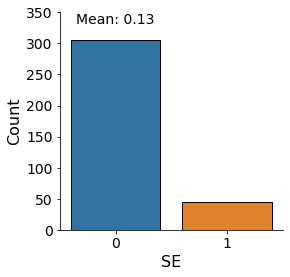

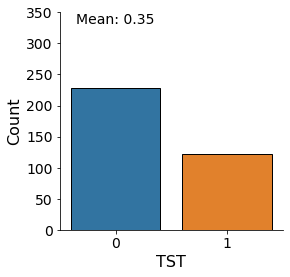

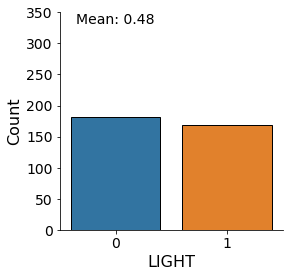

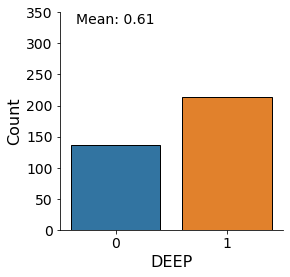

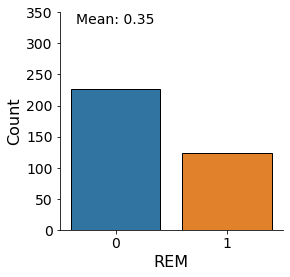

In [139]:
for fb_target in ["se","tst","light_percent","deep_percent","rem_percent"]:
    plot_summary_count(combined_fb_simple,f"{fb_target}_binary")

### Self-Report
And now for the self-report metrics

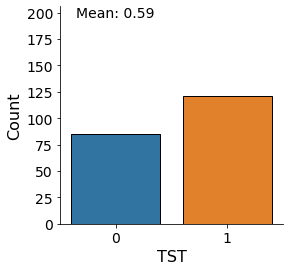

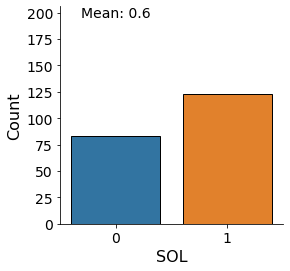

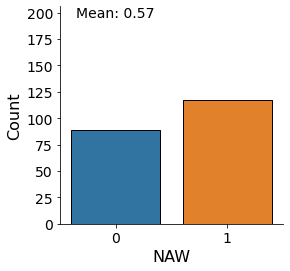

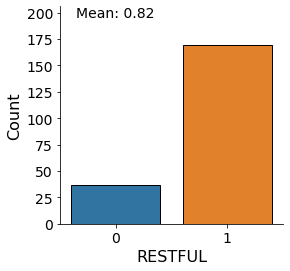

In [140]:
for sr_target in ["tst","sol","naw","restful"]:
    plot_summary_count(combined_sr_simple,f"{sr_target}_binary")

<a id="prediction"></a>

# Prediction
Now that we have sufficiently explored the features, we can begin to try predicting various components of sleep quality. We will try a wide-variety of classifiers to determine which is the most applicable to solving our problem. The classifiers that we use can be seen in the following cell via the `import` statements.

## Linear Regression
We use linear regression as a first step in the analysis.

In [303]:
from sklearn.linear_model import LinearRegression

In [376]:
class linear_model:
    
    def __init__(self):
        pass
    
    def set_x_and_y(self, feature_set, target_set, features=["co2_median","co_median","pm2p5_mass_median","no2_median","temperature_c_median","rh_median","steps","sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes"], target="tst"):
        """sets the x and y parameters"""
        # for reference
        self.target_label = target
        self.feature_labels = features
        combined = feature_set.merge(right=target_set,on=["beiwe","end_date"])
        combined_simple = combined[[column for column in combined.columns if not column.endswith("binary") and not column.endswith("x") and not column.endswith("y")]]
        combined_simple.dropna(inplace=True)
        # getting x and y
        self.y = combined_simple[[f"{target}"]]
        self.X = combined_simple[[column for column in combined.columns if column.endswith("median") or column.endswith("minutes") or column == "steps"]]

    def set_model(self):
        """runs a linear leasts-squares regression model"""
        self.model = LinearRegression(normalize=True).fit(self.X,self.y)
        temp = pd.DataFrame(data={"feature":self.feature_labels,"coefficient":self.model.coef_[0]})
        self.coefficients = temp.sort_values("coefficient")
    
    def run(self, feature_set, target_set, features=["co2_median","co_median","pm2p5_mass_median","no2_median","temperature_c_median","rh_median","steps","sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes"], target="tst"):
        """runs the linear model"""
        self.set_x_and_y(feature_set, target_set, features, target)
        self.set_model()
        print(self)
        
    def get_r2(self):
        """gets r2"""
        return round(self.model.score(self.X, self.y),3)
    
    def get_coefs(self):
        """gets coefficients of the model"""
        return self.coefficients
    
    def __str__(self):
        """output"""
        print("Linear Model")
        try:
            print("Observations:", len(self.X))
            print("Score:", self.get_r2())
            print("Coefficients:")
            for feature, c in zip(self.get_coefs().iloc[:,0], self.get_coefs().iloc[:,1]):
                print(f"\t{feature}:\t{round(c,4)}")
        except AttributeError:
            print("No Model found")
            
        return ""

In [377]:
lm = linear_model()
lm.run(ieq_and_activity, fbsq)

Linear Model
Observations: 138
Score: 0.241
Coefficients:
	no2_median:	-0.2179
	pm2p5_mass_median:	-0.0376
	temperature_c_median:	-0.0134
	co_median:	-0.0045
	lightly_active_minutes:	-0.0037
	fairly_active_minutes:	-0.0028
	co2_median:	-0.0003
	steps:	0.0
	very_active_minutes:	0.0002
	sedentary_minutes:	0.0003
	rh_median:	0.0553



## Classification

In [278]:
# Logistic Regressions
from sklearn.linear_model import LogisticRegression
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Bernoulli Naive Bayes
from sklearn.naive_bayes import BernoulliNB
# KNN
from sklearn.neighbors import KNeighborsClassifier
# Support Vector
from sklearn.svm import SVC
# Multi-Layer Perceptron
from sklearn.neural_network import MLPClassifier
# ADAboost
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier
# Bagging
from sklearn.ensemble import BaggingClassifier

To automate the prediction/evaluation process, we have created the class below that utilizes the following steps:
1. Feature and Target Data Split: The feature and target datasets are fed into the program, cross-referenced, and then split.
2. Train/Test Split: Data are split into a training and a testing split

In [274]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

class ieq_and_sq_prediction:
    
    def __init__(self):
        """initializes the model parameters"""
        self.classifier_model_params = {
            "logistic_regression": {
                "model":LogisticRegression(random_state=42,max_iter=500),
                "params": {
                    "fit_intercept":[True,False],
                    "solver":["lbfgs","liblinear"],
                }
            },
            "random_forest": {
                "model":RandomForestClassifier(random_state=42),
                "params": {
                    "n_estimators":[10,50,100],
                    "max_depth":[2,3,4,5],
                    "min_samples_split":[2,4],
                    "min_samples_leaf":[1,2],
                }
            },
            "bernoulli_naive_bayes": {
                "model":BernoulliNB(binarize=None),
                "params": {
                    "alpha":[0,0.5,1],
                }
            },
            "k-nearest_neighbor": {
                "model":KNeighborsClassifier(),
                "params": {
                    "n_neighbors":[3,5,7],
                    "weights":["uniform","distance"],
                    "p":[1,2],
                }
            },
            "support_vector": {
                "model":SVC(random_state=42),
                "params": {
                    "kernel":["linear","poly","sigmoid","rbf"],
                }
            },
            "multilayer_perceptron": {
                "model":MLPClassifier(random_state=42,solver="lbfgs",max_iter=500),
                "params": {
                    "hidden_layer_sizes":[1,10,50,100],
                    "activation":["identity","logistic"]
                }
            },
            "adaboost":{
                "model": AdaBoostClassifier(random_state=42),
                "params": {
                }
            },
            "gradientboost":{
                "model": GradientBoostingClassifier(random_state=42),
                "params": {
                    "max_depth":[1,2,3],
                }
            },
            "bagging":{
                "model":BaggingClassifier(random_state=42),
                "params": {
                    "n_estimators":[5,10,20],
                    "bootstrap_features":[False,True],
                }
            }
        }
    
    def get_features_and_targets(self, feature_set, target_set, target="tst"):
        """gets feature set and target set for the same observations"""
        self.target_label = target
        print(f"Getting Features and Target ({target})...")
        # selecting only important target
        target_set_reduced = target_set[["beiwe","end_date",f"{target}_binary"]]
        # combining datasets to get overlapping observations
        combined = feature_set.merge(right=target_set_reduced,on=["beiwe","end_date"])
        combined = combined.merge(right=combined["beiwe"].value_counts().rename("count"),left_on="beiwe",right_index=True,how="left")
        combined = combined[combined["count"] > 1]
        combined_simple = combined[[column for column in combined.columns if column.endswith("binary") or column in ["count","beiwe"]]]
        # splitting into features and targets
        targets = combined_simple[[f"{target}_binary"]]
        features = combined_simple.drop([f"{target}_binary","beiwe"],axis="columns")
        self.features = features
        self.targets = targets
        
    def split_data(self, test_size=0.33):
        """splits data into training and testing"""
        print("Splitting Data...")
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.features, self.targets, test_size=test_size, random_state=10, stratify=self.features["count"])
        self.X_train.drop("count",axis="columns",inplace=True)
        self.X_test.drop("count",axis="columns",inplace=True)
        
    def optimize_models(self):
        """runs gridsearch cv"""
        print("Testing Classifiers...")
        try:
            scores = []
            params = self.classifier_model_params
            for model_name, mp in params.items():
                s = datetime.now()
                print(f"\t{model_name.replace('_',' ').title()}")
                clf = GridSearchCV(mp["model"],mp["params"],cv=5,return_train_score=False)
                clf.fit(self.X_train,self.y_train)
                scores.append({
                    "model":model_name,
                    "best_score":clf.best_score_,
                    "best_params":clf.best_params_
                })
                print("\t\tElapsed Time:\t", datetime.now() - s)
                print(f"\t\tBest Score:\t{clf.best_score_}\n\t\tBest Params:\t{clf.best_params_}")

            results = pd.DataFrame(scores,columns=["model","best_score","best_params"])
            # getting and saving best model
            results.sort_values(["best_score"],ascending=False,inplace=True)
            self.results = results
            best = results.iloc[0,:]
            # outputting results
            print(f"\tBest Scoring Model:")
            print(f"\t\tModel:\t{best[0].replace('_',' ').title()}\n\t\tScore:\t{round(best[1],3)}\n\t\tParams:\t{best[2]}")
        except AttributeError:
            print("Training data do not exist - run split_data()")
        
    def train_model(self, model):
        """trains the specified model"""
        print("Training...")
        self.model = model # necessary if running functions separately
        try:
            self.X_train = self.X_train
            self.X_test = self.X_test
            self.model.fit(self.X_train,self.y_train)
        except AttributeError:
            print("Training data do not exist - run split_data()")
    
    def predict(self):
        """gets the predicted results based on the model provided for the given target"""
        print("Predicting...")
        try:
            self.predictions = self.model.predict(self.X_test)
            
            self.score = metrics.precision_score(self.y_test,self.predictions,average="weighted")

            scores = cross_val_score(self.model, self.X_train, self.y_train, cv=5, scoring='precision_weighted')
            print("\tCross Validation Scores:")
            for scr in scores:
                print(f"\t\t{round(scr,3)}")
            print(f"\tAverage:\t{round(scores.mean(),3)}")
            print(f"\tModel Score: {round(self.score,3)}")
        except AttributeError:
            print("Missing attributes - make sure you split the data and trained the model")
        
    def plot_confusion_matrix(self, save=False, target_label=""):
        """plots confusion matrix"""
        print("Evaluating...")
        # get confusion matrix
        cm = metrics.confusion_matrix(self.y_test,self.predictions)
        cm_df = pd.DataFrame(cm)
        # plot confusion matrix as heatmap
        fig, ax = plt.subplots(figsize=(5,4))
        sns.heatmap(cm_df,annot=True,cmap="Blues",ax=ax)
        ax.set_xlabel("Predicted Label",fontsize=16)
        ax.set_ylabel("True Label",fontsize=16)
        if save:
            plt.savefig(f"../../../Documents/sbac_2021/project/figures/confusion_matrix-{target_label}.pdf")
        plt.show()
        plt.close()
        
    def set_feature_importance(self,plot=False):
        """gets feature importance from classifier models"""
        try:
            # getting importance df
            importance = pd.DataFrame(data={"feature":[value.split('_')[0] for value in self.features.columns],"importance":self.model.feature_importances_})
            importance.sort_values("importance",inplace=True)
            self.feature_importance = importance
            if plot:
                # getting color map
                my_cmap = plt.get_cmap("Blues")
                rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
                # plotting
                fig, ax = plt.subplots(figsize=(6,4))
                ax.barh(importance["feature"],importance["importance"],color=my_cmap(rescale(importance["importance"])),edgecolor="black",tick_label=[visualize.get_label(label) for label in importance["feature"]])
                # x-axis
                plt.xticks(fontsize=12)
                ax.set_xlabel("Importance",fontsize=14)
                # y-axis
                plt.yticks(fontsize=12)
                ax.set_ylabel("Feature",fontsize=14)
                # remainder
                for loc in ["top","right"]:
                    ax.spines[loc].set_visible(False)
                plt.show()
                plt.close()
        except AttributeError as e:
            print(e)
            
    def run(self, feature_set, target_set, target="tst", test_size=0.33):
        """runs the class: split, test, predict, evaluate"""
        self.get_features_and_targets(feature_set, target_set, target=target)
        self.split_data(test_size=test_size)
        # gridsearch on models
        self.optimize_models()
        # saves the best model, trains on the best model, predicts with the model, and plots the confusion matrix
        self.model = self.classifier_model_params[self.results.iloc[0,:]["model"]]["model"].set_params(**self.results.iloc[0,:]["best_params"])
        self.train_model(self.model)
        self.predict()
        self.plot_confusion_matrix()
        self.set_feature_importance(plot=True)

Getting Features and Target (se)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.126762
		Best Score:	0.8717853839037929
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:17.705348
		Best Score:	0.8717853839037929
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.068036
		Best Score:	0.8717853839037929
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.378612
		Best Score:	0.8630897317298798
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Support Vector
		Elapsed Time:	 0:00:00.099142
		Best Score:	0.876040703052729
		Best Params:	{'kernel': 'poly'}
	Multilayer Perceptron
		Elapsed Time:	 0:00:02.551226
		Best Score:	0.8717853839037929
		Best Params:	{'activation': 'identity', 'hidden_layer_sizes': 1}
	Adaboost
		Elapsed Time:	 0:00:00.398107
		Best Score:	0.86753006

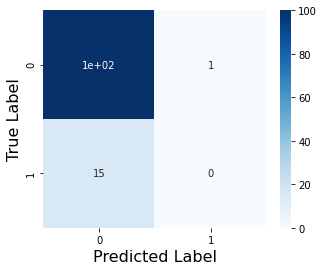

'SVC' object has no attribute 'feature_importances_'
Getting Features and Target (tst)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.124084
		Best Score:	0.6493987049028677
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:18.009449
		Best Score:	0.6666975023126734
		Best Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.065091
		Best Score:	0.6451433857539315
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.371914
		Best Score:	0.6413506012950971
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Support Vector
		Elapsed Time:	 0:00:00.104132
		Best Score:	0.6495837187789084
		Best Params:	{'kernel': 'linear'}
	Multilayer Perceptron
		Elapsed Time:	 0:00:02.943139
		Best Score:	0.645235892691952
		Best Params:	{'activation': 'identity', 'hidden_layer_sizes': 1}
	Adaboost

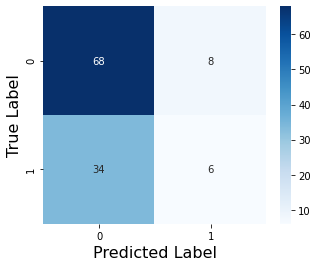

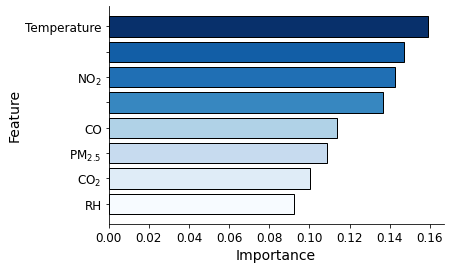

Getting Features and Target (light_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.125917
		Best Score:	0.5211840888066605
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.910932
		Best Score:	0.5214616096207216
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064907
		Best Score:	0.5383903792784459
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.372427
		Best Score:	0.5130434782608695
		Best Params:	{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	Support Vector
		Elapsed Time:	 0:00:00.105428
		Best Score:	0.5169287696577243
		Best Params:	{'kernel': 'linear'}
	Multilayer Perceptron
		Elapsed Time:	 0:00:03.536510
		Best Score:	0.5129509713228492
		Best Params:	{'activation': 'logistic', 'hidden_layer_sizes': 10}
	Adaboost
		Elapsed Time:	 0:00:00.394396
		Best 

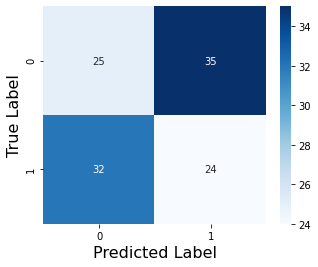

'BernoulliNB' object has no attribute 'feature_importances_'
Getting Features and Target (deep_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.142901
		Best Score:	0.6025901942645698
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.224380
		Best Score:	0.606845513413506
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.075941
		Best Score:	0.5984273820536541
		Best Params:	{'alpha': 0.5}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.384568
		Best Score:	0.5596669750231268
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Support Vector
		Elapsed Time:	 0:00:00.108271
		Best Score:	0.606845513413506
		Best Params:	{'kernel': 'linear'}
	Multilayer Perceptron
		Elapsed Time:	 0:00:03.238459
		Best Score:	0.5940795559666976
		Best Params:	{'activation': 'identity', 'hidden_layer_si

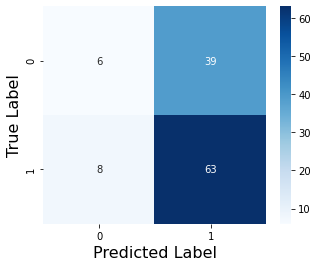

'BaggingClassifier' object has no attribute 'feature_importances_'
Getting Features and Target (rem_percent)...
Splitting Data...
Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.111099
		Best Score:	0.6451433857539316
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Random Forest
		Elapsed Time:	 0:00:16.208192
		Best Score:	0.6495837187789084
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063808
		Best Score:	0.6365402405180388
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.376072
		Best Score:	0.555781683626272
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Support Vector
		Elapsed Time:	 0:00:00.103250
		Best Score:	0.6495837187789084
		Best Params:	{'kernel': 'linear'}
	Multilayer Perceptron
		Elapsed Time:	 0:00:02.961986
		Best Score:	0.6325624421831637
		Best Params:	{'activation': 'logistic', 'hidden_l

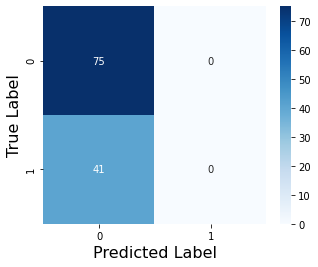

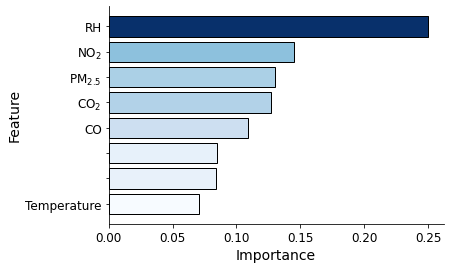

In [208]:
trial = ieq_and_sq_prediction()
for fb_target in ["se","tst","light_percent","deep_percent","rem_percent"]:
    trial.run(ieq_and_activity,fbsq,fb_target)

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.134232
		Best Score:	0.5542528735632184
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.142373
		Best Score:	0.6213793103448275
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.066247
		Best Score:	0.5606896551724139
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.348007
		Best Score:	0.5820689655172414
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Support Vector
		Elapsed Time:	 0:00:00.093764
		Best Score:	0.6013793103448276
		Best Params:	{'kernel': 'rbf'}
	Multilayer Perceptron
		Elapsed Time:	 0:00:02.231277
		Best Score:	0.6149425287356322
		Best Params:	{'activation': 'logistic', 'hidden_layer_sizes': 1}
	Adaboost
		Elapsed Time:	 0:00:00.383638
		Best Score:	0.5473563218390805
		Best Params:	{}
	Gradientboost
		Elapsed 

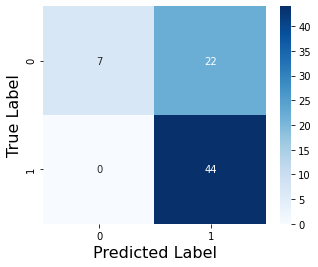

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.113230
		Best Score:	0.6087356321839081
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Random Forest
		Elapsed Time:	 0:00:16.021758
		Best Score:	0.5949425287356321
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.065583
		Best Score:	0.5816091954022988
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.352776
		Best Score:	0.5740229885057471
		Best Params:	{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Support Vector
		Elapsed Time:	 0:00:00.102109
		Best Score:	0.5947126436781609
		Best Params:	{'kernel': 'linear'}
	Multilayer Perceptron
		Elapsed Time:	 0:00:02.531838
		Best Score:	0.6016091954022988
		Best Params:	{'activation': 'identity', 'hidden_layer_sizes': 1}
	Adaboost
		Elapsed Time:	 0:00:00.391381
		Best Score:	0.6016091954022988
		Best Params:	{}
	Gradientboost
		Ela

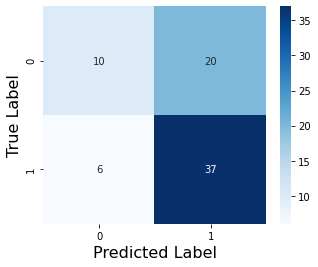

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.114574
		Best Score:	0.5420689655172414
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.088686
		Best Score:	0.6218390804597702
		Best Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.064208
		Best Score:	0.5344827586206897
		Best Params:	{'alpha': 0.5}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.345732
		Best Score:	0.6547126436781608
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
	Support Vector
		Elapsed Time:	 0:00:00.093853
		Best Score:	0.6218390804597702
		Best Params:	{'kernel': 'poly'}
	Multilayer Perceptron
		Elapsed Time:	 0:00:02.388780
		Best Score:	0.668735632183908
		Best Params:	{'activation': 'logistic', 'hidden_layer_sizes': 10}
	Adaboost
		Elapsed Time:	 0:00:00.388458
		Best Score:	0.5285057471264368
		Best Params:	{}
	Gradientboost
		Elaps

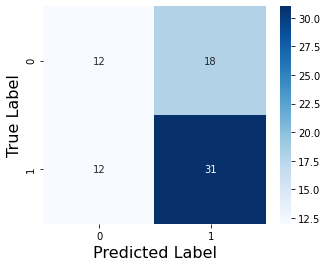

Testing Classifiers...
	Logistic Regression
		Elapsed Time:	 0:00:00.123469
		Best Score:	0.8577011494252874
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:16.128514
		Best Score:	0.8439080459770114
		Best Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}
	Bernoulli Naive Bayes
		Elapsed Time:	 0:00:00.063230
		Best Score:	0.8310344827586207
		Best Params:	{'alpha': 0}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:00.345271
		Best Score:	0.8508045977011495
		Best Params:	{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Support Vector
		Elapsed Time:	 0:00:00.091059
		Best Score:	0.8374712643678162
		Best Params:	{'kernel': 'rbf'}
	Multilayer Perceptron
		Elapsed Time:	 0:00:01.980593
		Best Score:	0.8372413793103448
		Best Params:	{'activation': 'logistic', 'hidden_layer_sizes': 50}
	Adaboost
		Elapsed Time:	 0:00:00.381890
		Best Score:	0.8310344827586207
		Best Params:	{}
	Gradientboost
		Elapsed 

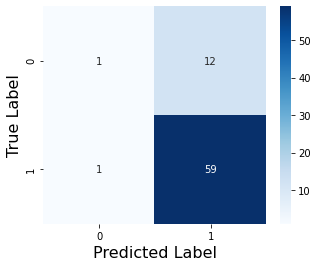

In [157]:
trial = ieq_and_sq_prediction()
for sr_target in ["tst","sol","naw","restful"]:
    trial.run(ieq_and_activity,srsq,sr_target)

# Model Refinement
Now we want to refine the model by considering the best models from each of the targets and looking more in depth at the relevant features and the outcome.

In [275]:
test = ieq_and_sq_prediction()
test.get_features_and_targets(ieq_and_activity,fbsq)

Getting Features and Target (tst)...


In [276]:
test.split_data()

Splitting Data...


In [256]:
X_train, X_test, y_train, y_test = train_test_split(test.features, test.targets, test_size=0.33, random_state=10, stratify=test.features["count"])

In [277]:
test.X_train

,co2_median_binary,co_median_binary,pm2p5_mass_median_binary,no2_median_binary,temperature_c_median_binary,rh_median_binary,active_binary,steps_binary
205,0,0,1,0,1,1,1,1
28,1,1,1,0,0,0,0,0
242,0,1,0,0,0,0,1,0
89,0,1,1,0,0,0,1,0
211,1,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...
77,0,0,1,0,0,0,0,0
3,1,1,1,1,0,1,1,0
144,1,1,0,0,0,1,1,0
170,0,0,1,0,1,0,0,0
